In [46]:
import glob
import pandas as pd
def get_log_props(log_path):
    parts = log_path.split('-')
    if len(parts) > 5:
        topic = parts[1]
        depth = parts[2].split('user')[-1]
        modality = parts[3]
        strat = parts[4]
        prob = parts[5].split(".")[0]

        return (topic, depth, modality, strat, prob)
    else:
        return 


corpus = "nyt"

log_root_path = "workspace/sims/output/"
#load all logs
log_files = glob.glob(f"{log_root_path}{corpus}*.log")
topics = set()
depths = set()
modalities  = set()
strats = set()
probs = set()

log_cnt = 0

log_df = pd.DataFrame(columns=['Depth', 'Modality', 'Strat', 'Probability', 'Topics'])

for path in log_files:
    res = get_log_props(path)

    if res:
        log_cnt +=1
        topic, depth, modality, strat, prob = res
        topics.add(topic)
        depths.add(depth)
        modalities.add(modality)
        strats.add(strat)
        probs.add(prob)

        row = {'Depth' : depth, 'Modality': modality, 'Strat' : strat, 'Probability' : prob,  'Topics' : topic}
        log_df = pd.concat([log_df, pd.DataFrame([row])])


print(f"number of log files: {log_cnt}")


number of log files: 1200


# Evaluations

## Modalities

### sDCG 

In [47]:
topics = list(set([int(log.split('-')[2]) for log in log_files]))

In [48]:
topics_to_analyze = topics

### Effort vs. Effect

## Depth evaluation

### sDCG

### Effort vs. Effect

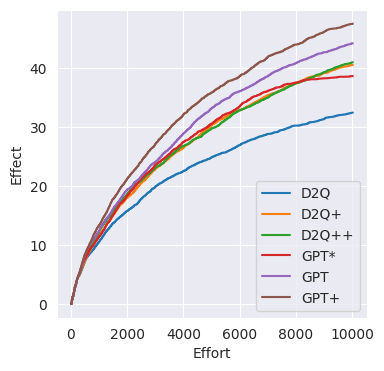

In [50]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')


qrels_path = f"workspace/data/{corpus}/{corpus}_qrels"


qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

depth_eval = {}
gain_all = {}

q_strats = ["D2Q", "D2Q+", "D2Q++",'GPT*','GPT', 'GPT+']
snippets = ["perfect", "navigational", "informational", "almostrandom"]
stop_decs = ['t50nr', 't110nr', '10rpp', '20rpp']
models = ['bm25', 'monoT5']


q_strat = q_strats[5]
model = models[0]
stop_dec = stop_decs[-2]
snippet = snippets[2]


depths = q_strats


for depth in depths:

    for topic in topics_to_analyze:
        
        log_path = log_root_path + f"{corpus}" +"-"+ model + "-" + str(topic) + "-" + depth + "-"+ snippet + "-"  + stop_dec+ ".log"
        query_logs = {}
                    
        query = ''
        results = []
        
        _gain = 0
        gain = {}                
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')
                
                if len(logs) > 4 and logs[0] == 'ACTION':

                    if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                        result = logs[-1].replace("b'", "").replace("'", "").strip('\n')
                        if qrels.get((str(topic),result)):
                            _gain += int(qrels.get((str(topic),result)))
                    if True or int(logs[3]) < 300:
                        gain[int(logs[3])] = _gain
        gain_all[topic] = gain
    depth_eval[depth] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
pd.DataFrame.from_dict(depth_eval).sort_index().fillna(method='ffill').plot(xlabel='Effort', ylabel='Effect', figsize=(4,4))

#ax = plt.gcf().axes[0]
#lines = ax.get_lines()
#for line in lines:
#    print(line.get_color())
    

#lines[0].set_color("#d62728") 
#lines[3].set_color("#1f77b4") 

#plt.legend()

aspects = [q_strat, model, stop_dec, corpus]
fig_name = f'/workspace/figures/effort.effect.'
for aspect in aspects:
    if aspect not in depths:
        fig_name += f"{aspect}."
    else:
        fig_name += ".".join(depths) + "."

fig_name += "pdf"
plt.savefig(fig_name, bbox_inches="tight")
plt.show()

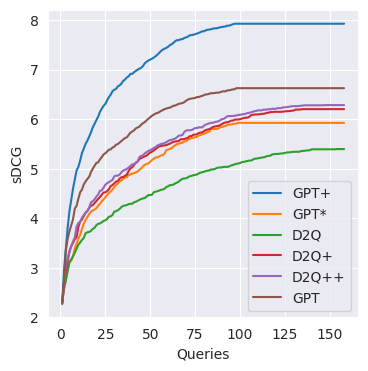

In [40]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')

qrels_path = f"workspace/data/{corpus}/{corpus}_qrels"

qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

def dcg(results, topic):
    _dcg = 0
    for i,result in enumerate(results):
        _doc = qrels.get((str(topic),result))
        
        if _doc is not None:
            _dcg += int(_doc) / (1 + math.log(i+1, b))

    return _dcg

b = 2
bq = 4

depth_eval = {}
gain_all = {}


for depth in depths:
    for topic in topics_to_analyze:

        log_path = log_root_path + f"{corpus}" +"-"+ model + "-" + str(topic) + "-" + depth + "-"+ snippet + "-"  + stop_dec+ ".log"
        query_logs = {}

        query = ''
        results = []
                        
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')

                if logs[1] == 'QUERY':
                    if len(query) > 0:
                        query_logs[query] = results
                    results = []
                    query = ' '.join(logs[4:]).strip('\n')
                    
                if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                    results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))      

        gain = {}
        _gain = 0.0

        for q, query in enumerate(query_logs.keys()):
            results = query_logs.get(query)    
            _gain += dcg(results, topic) / (1 + math.log(q + 1, bq))
            gain[q+1] = _gain

        gain_all[topic] = gain
    depth_eval[depth] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
pd.DataFrame.from_dict(depth_eval).sort_index().fillna(method='ffill').plot(xlabel='Queries', ylabel='sDCG', figsize=(4,4))

aspects = [q_strat, model, stop_dec, corpus]
fig_name = f'/workspace/figures/sDCG.'
for aspect in aspects:
    if aspect not in depths:
        fig_name += f"{aspect}."
    else:
        fig_name += ".".join(depths)+ "."

fig_name += "pdf"
plt.savefig(fig_name, bbox_inches="tight") 
plt.show()

sRBP

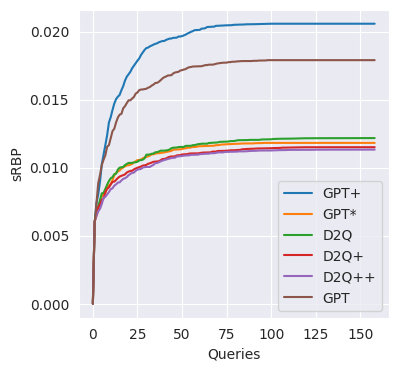

In [41]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')

qrels_path = f"workspace/data/{corpus}/{corpus}_qrels"
qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

p_srbp = 0.99
b_srbp = 0.6

# Discount function
def d_srbp(b, p, m, n):
    def spow(base, exp):
        if base == 0 and exp == 0:
            return 1.0
        else:
            return base**exp
        
    if b == 1.0 and p == 1.0:
        if m == 0:
            return spow(b*p, n)
        else:
            return 0.0
    
    else:
        return spow((p - b*p)/(1.0 - b*p), m)*spow(b*p, n)
# b: balance parameter (balances between reformulating queries and examining more documents)
# p: persistence parameter (persistence of users in continuing search)
# m: reformulation
# n: document rank

def s_rbp(b, p, log_path, topic, qrels):
    res = 0.0
    n = 0
    m = 0
    
    query_rbp = {}

    with open(log_path) as f_in:

        for line in f_in.readlines():
            logs = line.split(' ')

            if logs[1] == 'QUERY': # new query, increase reformulation count
                query_rbp[m] = (1-p)*res # sRBP after each query
                m += 1
                n = 0
            
            elif logs[1] == 'SNIPPET': # showing new document from the ranking, increase rank count; DOCUMENT is not relevant here because it is just repeated after SNIPPET
                n += 1
                                
            elif logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT': # add d_srbp value for relevant document to the result
                if qrels.get((str(topic),logs[5].replace("b'", "").replace("'", "").strip('\n'))):
                    if int(qrels.get((str(topic),logs[5].replace("b'", "").replace("'", "").strip('\n')))) > 0:
                        res += d_srbp(b, p, m, n)
                        #print('dsrbp: ' + str(d_srbp(b,p,m,n)))
                        #print('res: ' + str(res))

    return (1-p)*res, query_rbp

qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

depth_eval = {}
gain_all = {}



for depth in depths:
    for topic in topics_to_analyze:

        log_path = log_root_path + f"{corpus}" +"-"+ model + "-" + str(topic) + "-" + depth + "-"+ snippet + "-"  + stop_dec+ ".log"
        query_logs = {}

        query = ''
        results = []
                        
        with open(log_path) as f_in:
            srbp = s_rbp(b_srbp, p_srbp, log_path, topic, qrels)[1]

        gain_all[topic] = srbp
    depth_eval[depth] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
pd.DataFrame.from_dict(depth_eval).sort_index().fillna(method='ffill').plot(xlabel='Queries', ylabel='sRBP', figsize=(4,4))

aspects = [q_strat, model, stop_dec, corpus]
fig_name = f'/workspace/figures/sRBP.'
for aspect in aspects:
    if aspect not in depths:
        fig_name += f"{aspect}."
    else:
        fig_name += ".".join(depths) + "."

fig_name += "pdf"
plt.savefig(fig_name, bbox_inches="tight")
plt.show()


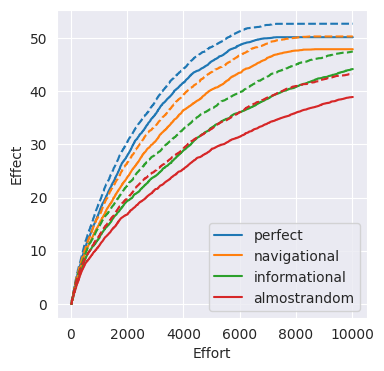

In [55]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')


qrels_path = f"workspace/data/{corpus}/{corpus}_qrels"


qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

depth_eval = {}
gain_all = {}

q_strats = ['GPT+', 'GPT*', "D2Q", "D2Q+", "D2Q++", 'GPT']
snippets = ["perfect", "navigational", "informational", "almostrandom"]
stop_decs = ['10rpp', '20rpp', 't50nr', 't110nr']
models = ['bm25', 'monoT5']


q_strat = q_strats[5]
model = models[0]
stop_dec = stop_decs[0]
snippet = snippets[2]


depths = snippets
depths2 = models

for depth2 in depths2:
    for depth in depths:

        for topic in topics_to_analyze:
            
            log_path = log_root_path + f"{corpus}" +"-"+ depth2 + "-" + str(topic) + "-" + q_strat + "-"+ depth + "-"  + stop_dec + ".log"
            query_logs = {}
                        
            query = ''
            results = []
            
            _gain = 0
            gain = {}                
            with open(log_path) as f_in:

                for line in f_in.readlines():
                    logs = line.split(' ')
                    
                    if len(logs) > 4 and logs[0] == 'ACTION':

                        if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                            result = logs[-1].replace("b'", "").replace("'", "").strip('\n')
                            if qrels.get((str(topic),result)):
                                _gain += int(qrels.get((str(topic),result)))
                        if True or int(logs[3]) < 1000:
                            gain[int(logs[3])] = _gain
            gain_all[topic] = gain
        depth_eval[f"{depth2}-{depth}"] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()

eval_df = pd.DataFrame.from_dict(depth_eval).sort_index().fillna(method='ffill')

eval_df.plot(xlabel='Effort', ylabel='Effect', figsize=(4,4))


ax = plt.gcf().axes[0]
lines = ax.get_lines()

color_map = {}
for i in range(len(lines)):
    color_map[i] = lines[i].get_color()

for line in lines:

    line_color = color_map[depths.index(line.get_label().split("-")[-1])]
    line.set_color(line_color)

    if depths2[1] in line.get_label():
        line.set_linestyle("--")
        line.set_label(None)
    else:
        line.set_label(line.get_label().split("-")[-1])
    


plt.legend()

aspects = [q_strat, model, stop_dec, corpus]
fig_name = f'/workspace/figures/effort.effect.'
for aspect in aspects:
    if aspect not in depths:
        fig_name += f"{aspect}."
    else:
        fig_name += ".".join(depths) + "."

fig_name += "pdf"
plt.savefig(fig_name, bbox_inches="tight")
plt.show()

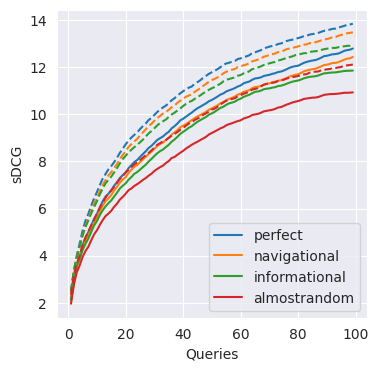

In [57]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')

qrels_path = f"workspace/data/{corpus}/{corpus}_qrels"

qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

def dcg(results, topic):
    _dcg = 0
    for i,result in enumerate(results):
        _doc = qrels.get((str(topic),result))
        
        if _doc is not None:
            _dcg += int(_doc) / (1 + math.log(i+1, b))

    return _dcg

b = 2
bq = 4

depth_eval = {}
gain_all = {}


for depth2 in depths2:
    for depth in depths:
        for topic in topics_to_analyze:

            log_path = log_root_path + f"{corpus}" +"-"+ depth2 + "-" + str(topic) + "-" + q_strat + "-"+ depth + "-"  + stop_dec+ ".log"
            query_logs = {}

            query = ''
            results = []
                            
            with open(log_path) as f_in:

                for line in f_in.readlines():
                    logs = line.split(' ')

                    if logs[1] == 'QUERY':
                        if len(query) > 0:
                            query_logs[query] = results
                        results = []
                        query = ' '.join(logs[4:]).strip('\n')
                        
                    if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                        results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))      

            gain = {}
            _gain = 0.0

            for q, query in enumerate(query_logs.keys()):
                results = query_logs.get(query)    
                _gain += dcg(results, topic) / (1 + math.log(q + 1, bq))
                gain[q+1] = _gain

            gain_all[topic] = gain
        depth_eval[f"{depth2}-{depth}"] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()


pd.DataFrame.from_dict(depth_eval).sort_index().fillna(method='ffill').plot(xlabel='Queries', ylabel='sDCG', figsize=(4,4))


ax = plt.gcf().axes[0]
lines = ax.get_lines()
color_map = {}
for i in range(len(lines)):
    color_map[i] = lines[i].get_color()

for line in lines:

    line_color = color_map[depths.index(line.get_label().split("-")[-1])]
    line.set_color(line_color)

    if depths2[1] in line.get_label():
        line.set_linestyle("--")
        line.set_label(None)
    else:
        line.set_label(line.get_label().split("-")[-1])
    


plt.legend()

aspects = [q_strat, model, stop_dec, corpus]
fig_name = f'/workspace/figures/sDCG.'
for aspect in aspects:
    if aspect not in depths:
        fig_name += f"{aspect}."
    else:
        fig_name += ".".join(depths) + "."

fig_name += "pdf"
plt.savefig(fig_name, bbox_inches="tight")
plt.show()

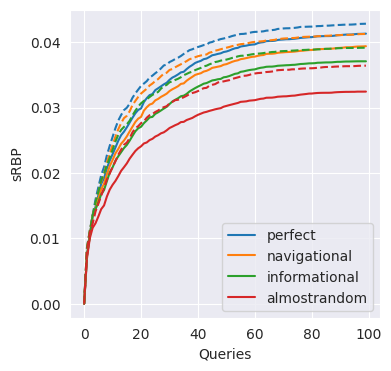

In [58]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')

qrels_path = f"workspace/data/{corpus}/{corpus}_qrels"
qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

p_srbp = 0.99
b_srbp = 0.6

# Discount function
def d_srbp(b, p, m, n):
    def spow(base, exp):
        if base == 0 and exp == 0:
            return 1.0
        else:
            return base**exp
        
    if b == 1.0 and p == 1.0:
        if m == 0:
            return spow(b*p, n)
        else:
            return 0.0
    
    else:
        return spow((p - b*p)/(1.0 - b*p), m)*spow(b*p, n)
# b: balance parameter (balances between reformulating queries and examining more documents)
# p: persistence parameter (persistence of users in continuing search)
# m: reformulation
# n: document rank

def s_rbp(b, p, log_path, topic, qrels):
    res = 0.0
    n = 0
    m = 0
    
    query_rbp = {}

    with open(log_path) as f_in:

        for line in f_in.readlines():
            logs = line.split(' ')

            if logs[1] == 'QUERY': # new query, increase reformulation count
                query_rbp[m] = (1-p)*res # sRBP after each query
                m += 1
                n = 0
            
            elif logs[1] == 'SNIPPET': # showing new document from the ranking, increase rank count; DOCUMENT is not relevant here because it is just repeated after SNIPPET
                n += 1
                                
            elif logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT': # add d_srbp value for relevant document to the result
                if qrels.get((str(topic),logs[5].replace("b'", "").replace("'", "").strip('\n'))):
                    if int(qrels.get((str(topic),logs[5].replace("b'", "").replace("'", "").strip('\n')))) > 0:
                        res += d_srbp(b, p, m, n)
                        #print('dsrbp: ' + str(d_srbp(b,p,m,n)))
                        #print('res: ' + str(res))

    return (1-p)*res, query_rbp

qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

depth_eval = {}
gain_all = {}


for depth2 in depths2:
    for depth in depths:
        for topic in topics_to_analyze:

            log_path = log_root_path + f"{corpus}" +"-"+ depth2 + "-" + str(topic) + "-" + q_strat + "-"+ depth + "-"  + stop_dec+ ".log"
            query_logs = {}

            query = ''
            results = []
                            
            with open(log_path) as f_in:
                srbp = s_rbp(b_srbp, p_srbp, log_path, topic, qrels)[1]

            gain_all[topic] = srbp
        depth_eval[f"{depth2}-{depth}"] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
pd.DataFrame.from_dict(depth_eval).sort_index().fillna(method='ffill').plot(xlabel='Queries', ylabel='sRBP', figsize=(4,4))



ax = plt.gcf().axes[0]
lines = ax.get_lines()
color_map = {}
for i in range(len(lines)):
    color_map[i] = lines[i].get_color()

for line in lines:

    line_color = color_map[depths.index(line.get_label().split("-")[-1])]
    line.set_color(line_color)

    if depths2[1] in line.get_label():
        line.set_linestyle("--")
        line.set_label(None)
    else:
        line.set_label(line.get_label().split("-")[-1])
    


plt.legend()

aspects = [q_strat, model, stop_dec, corpus]
fig_name = f'/workspace/figures/sRBP.'
for aspect in aspects:
    if aspect not in depths:
        fig_name += f"{aspect}."
    else:
        fig_name += ".".join(depths) + "."

fig_name += "pdf"
plt.savefig(fig_name, bbox_inches="tight")
plt.show()


## Browsing behavior

### sDCG

### Effort vs. Effect

In [ ]:
df_types = {}

for type in query_types:
    query_df = pd.DataFrame.from_dict(query_type_eval_all[type], orient="index").stack().to_frame()
    query_df = pd.DataFrame(query_df[0].values.tolist(), index=query_df.index).reset_index(names=['topic', 'query'])
    query_df = query_df.rename(columns={0: 'gain'})
    query_df = query_df[query_df.apply(lambda row: row['query'] <=50, axis=1)]
    df_types[type] = query_df

sns.lineplot(data=df_types['d2qfeedback'], x='query', y='gain', label="doc2query feedback")
sns.lineplot(data=df_types['d2qNofeedback'], x='query', y='gain',  label="doc2query no feedback")
sns.lineplot(data=df_types['gpt'], x='query', y='gain', label="gpt")
#plt.legend(loc="upper left")

In [ ]:
#check how many docs get examined per query with 110nr

In [7]:
path  = "/workspace/sims/output/nyt-bm25-307-GPT-informational-t110nr.log"

total_doc_exam = []
total_snippet_exam = []
current_doc_exam = 0
current_snippet_exam = 0
with open(path) as f:
    for line in f.readlines():
        parts = line.split(" ")

        if parts[0] == "INFO":
            continue
        if parts[1] == 'QUERY':
            total_doc_exam.append(current_doc_exam)
            total_snippet_exam.append(current_snippet_exam)
            current_doc_exam = 0
            current_snippet_exam = 0
        elif parts[4] == "EXAMINING_DOCUMENT":
            current_doc_exam +=1
        
        elif parts[1] == "SNIPPET":
            current_snippet_exam +=1


In [8]:
total_snippet_exam

[0,
 100,
 15,
 22,
 100,
 15,
 22,
 49,
 16,
 29,
 21,
 15,
 22,
 9,
 7,
 9,
 8,
 32,
 15,
 35,
 29,
 15,
 40,
 15,
 22,
 16,
 36,
 22,
 22,
 26,
 32,
 22,
 21,
 16,
 22,
 22,
 42,
 29,
 15,
 22,
 22,
 22,
 45,
 29,
 15,
 35,
 19,
 42,
 29,
 29]